In [40]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vector,Vectors
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer,VectorIndexer
import pandas as pd

In [2]:
df = spark.read.csv('adult income.csv',header=True,inferSchema=True)

In [3]:
df.show()

+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
|age|       workclass|fnlwgt|   education|educationnum|maritalstatus|       occupation|  relationship| race|   sex|capitalgain|capitalloss|hoursperweek|nativecountry|income|
+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
| 90|         Private| 77053|     HS-grad|           9|      Widowed|             null| Not-in-family|White|Female|          0|       4356|          40|United-States| <=50K|
| 82|         Private|132870|     HS-grad|           9|      Widowed|  Exec-managerial| Not-in-family|White|Female|          0|       4356|          18|United-States| <=50K|
| 66|         Private|186061|Some-college|          10|      Widowed|             null|     Unmarried|Black|Female|          0|   

In [4]:
df.printSchema()
print(df.columns)
pd.DataFrame(df.take(5), columns=df.columns)

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educationnum: integer (nullable = true)
 |-- maritalstatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capitalgain: integer (nullable = true)
 |-- capitalloss: integer (nullable = true)
 |-- hoursperweek: integer (nullable = true)
 |-- nativecountry: string (nullable = true)
 |-- income: string (nullable = true)

['age', 'workclass', 'fnlwgt', 'education', 'educationnum', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'nativecountry', 'income']


,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,90,Private,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [155]:
import pandas as pd
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,30162,38.437901995888865,13.134664776856031,17,90
workclass,30162,None,None,Federal-gov,Without-pay
fnlwgt,30162,189793.83393011073,105652.9715285195,13769,1484705
education,30162,None,None,10th,Some-college
educationnum,30162,10.12131158411246,2.5499949188567363,1,16
maritalstatus,30162,None,None,Divorced,Widowed
occupation,30162,None,None,Adm-clerical,Transport-moving
relationship,30162,None,None,Husband,Wife
race,30162,None,None,Amer-Indian-Eskimo,White


In [5]:
print(df.head(1))

[Row(age=90, workclass='Private', fnlwgt=77053, education='HS-grad', educationnum=9, maritalstatus='Widowed', occupation=None, relationship='Not-in-family', race='White', sex='Female', capitalgain=0, capitalloss=4356, hoursperweek=40, nativecountry='United-States', income='<=50K')]


In [6]:
df.select('fnlwgt','age').describe().show()

+-------+------------------+------------------+
|summary|            fnlwgt|               age|
+-------+------------------+------------------+
|  count|             32561|             32561|
|   mean|189778.36651208502| 38.58164675532078|
| stddev|105549.97769702264|13.640432553581295|
|    min|             12285|                17|
|    max|           1484705|                90|
+-------+------------------+------------------+



In [7]:
bal_col = df.select('education','age',)
bal_col.show()

+------------+---+
|   education|age|
+------------+---+
|     HS-grad| 90|
|     HS-grad| 82|
|Some-college| 66|
|     7th-8th| 54|
|Some-college| 41|
|     HS-grad| 34|
|        10th| 38|
|   Doctorate| 74|
|     HS-grad| 68|
|Some-college| 41|
|   Doctorate| 45|
| Prof-school| 38|
|   Bachelors| 52|
|     Masters| 32|
|   Doctorate| 51|
| Prof-school| 46|
|        11th| 45|
|     Masters| 57|
|  Assoc-acdm| 22|
|   Bachelors| 34|
+------------+---+
only showing top 20 rows



In [8]:
df.filter("age > 25").select('income','age').show()

+------+---+
|income|age|
+------+---+
| <=50K| 90|
| <=50K| 82|
| <=50K| 66|
| <=50K| 54|
| <=50K| 41|
| <=50K| 34|
| <=50K| 38|
|  >50K| 74|
| <=50K| 68|
|  >50K| 41|
|  >50K| 45|
|  >50K| 38|
|  >50K| 52|
|  >50K| 32|
|  >50K| 51|
|  >50K| 46|
|  >50K| 45|
|  >50K| 57|
|  >50K| 34|
|  >50K| 37|
+------+---+
only showing top 20 rows



In [9]:
from  pyspark.sql.functions import format_number, col

In [10]:
cols1 = ['education', 'income']
df.select(cols1).show()

+------------+------+
|   education|income|
+------------+------+
|     HS-grad| <=50K|
|     HS-grad| <=50K|
|Some-college| <=50K|
|     7th-8th| <=50K|
|Some-college| <=50K|
|     HS-grad| <=50K|
|        10th| <=50K|
|   Doctorate|  >50K|
|     HS-grad| <=50K|
|Some-college|  >50K|
|   Doctorate|  >50K|
| Prof-school|  >50K|
|   Bachelors|  >50K|
|     Masters|  >50K|
|   Doctorate|  >50K|
| Prof-school|  >50K|
|        11th|  >50K|
|     Masters|  >50K|
|  Assoc-acdm|  >50K|
|   Bachelors|  >50K|
+------------+------+
only showing top 20 rows



In [11]:
df.filter(df.sex == 'Female').show()

+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
|age|       workclass|fnlwgt|   education|educationnum|maritalstatus|       occupation|  relationship| race|   sex|capitalgain|capitalloss|hoursperweek|nativecountry|income|
+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
| 90|         Private| 77053|     HS-grad|           9|      Widowed|             null| Not-in-family|White|Female|          0|       4356|          40|United-States| <=50K|
| 82|         Private|132870|     HS-grad|           9|      Widowed|  Exec-managerial| Not-in-family|White|Female|          0|       4356|          18|United-States| <=50K|
| 66|         Private|186061|Some-college|          10|      Widowed|             null|     Unmarried|Black|Female|          0|   

In [12]:
df.explain()

== Physical Plan ==
*FileScan csv [age#0,workclass#1,fnlwgt#2,education#3,educationnum#4,maritalstatus#5,occupation#6,relationship#7,race#8,sex#9,capitalgain#10,capitalloss#11,hoursperweek#12,nativecountry#13,income#14] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/ubuntu/Adult-income-level/adult income.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<age:int,workclass:string,fnlwgt:int,education:string,educationnum:int,maritalstatus:string...


In [13]:
print("Total data points:", df.count())

Total data points: 32561


In [14]:
missing_field_df = df.na.drop(subset="nativecountry")
missing_field_df.show()
print("Total data points:", missing_field_df.count())

+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
|age|       workclass|fnlwgt|   education|educationnum|maritalstatus|       occupation|  relationship| race|   sex|capitalgain|capitalloss|hoursperweek|nativecountry|income|
+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
| 90|         Private| 77053|     HS-grad|           9|      Widowed|             null| Not-in-family|White|Female|          0|       4356|          40|United-States| <=50K|
| 82|         Private|132870|     HS-grad|           9|      Widowed|  Exec-managerial| Not-in-family|White|Female|          0|       4356|          18|United-States| <=50K|
| 66|         Private|186061|Some-college|          10|      Widowed|             null|     Unmarried|Black|Female|          0|   

In [15]:
clean_df = missing_field_df.na.drop(subset="workclass")
clean_df.show()
print("Total data points:", clean_df.count())

+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
|age|       workclass|fnlwgt|   education|educationnum|maritalstatus|       occupation|  relationship| race|   sex|capitalgain|capitalloss|hoursperweek|nativecountry|income|
+---+----------------+------+------------+------------+-------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
| 90|         Private| 77053|     HS-grad|           9|      Widowed|             null| Not-in-family|White|Female|          0|       4356|          40|United-States| <=50K|
| 82|         Private|132870|     HS-grad|           9|      Widowed|  Exec-managerial| Not-in-family|White|Female|          0|       4356|          18|United-States| <=50K|
| 66|         Private|186061|Some-college|          10|      Widowed|             null|     Unmarried|Black|Female|          0|   

In [16]:
df = clean_df.na.drop(subset="occupation")
df.show()
print("Total data points:", df.count())

+---+----------------+------+------------+------------+------------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
|age|       workclass|fnlwgt|   education|educationnum|     maritalstatus|       occupation|  relationship| race|   sex|capitalgain|capitalloss|hoursperweek|nativecountry|income|
+---+----------------+------+------------+------------+------------------+-----------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
| 82|         Private|132870|     HS-grad|           9|           Widowed|  Exec-managerial| Not-in-family|White|Female|          0|       4356|          18|United-States| <=50K|
| 54|         Private|140359|     7th-8th|           4|          Divorced|Machine-op-inspct|     Unmarried|White|Female|          0|       3900|          40|United-States| <=50K|
| 41|         Private|264663|Some-college|          10|         Separated|   Prof-specialty|     Own-chil

In [17]:
print("Total data points:", df.count())

Total data points: 30162


([<matplotlib.axis.XTick at 0x7f99bdc59ac8>,
 <a list of 2 Text xticklabel objects>)

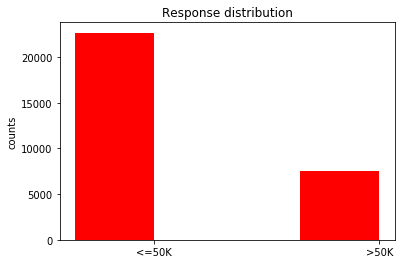

In [22]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
 
responses = df.groupBy('income').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Response distribution')
plt.xticks(ind + width/2., categories)

([<matplotlib.axis.XTick at 0x7f99bbbd05c0>,
 <a list of 2 Text xticklabel objects>)

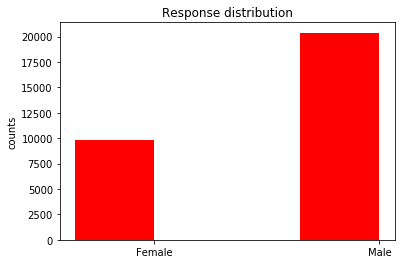

In [23]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
 
responses = df.groupBy('sex').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Response distribution')
plt.xticks(ind + width/2., categories)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


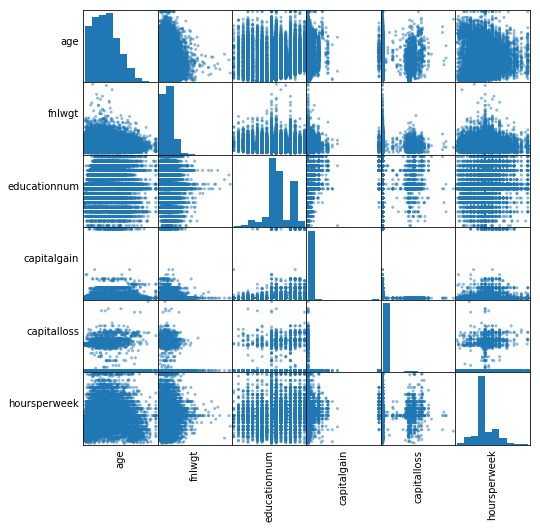

In [100]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [24]:
df.select('age', 'educationnum', 'hoursperweek').describe().show()

+-------+------------------+------------------+-----------------+
|summary|               age|      educationnum|     hoursperweek|
+-------+------------------+------------------+-----------------+
|  count|             30162|             30162|            30162|
|   mean|38.437901995888865| 10.12131158411246|40.93123798156621|
| stddev|13.134664776856031|2.5499949188567363|11.97998422927492|
|    min|                17|                 1|                1|
|    max|                90|                16|               99|
+-------+------------------+------------------+-----------------+



In [25]:

df.filter("hoursperweek > 25").select('income','age').show()

+------+---+
|income|age|
+------+---+
| <=50K| 54|
| <=50K| 41|
| <=50K| 34|
| <=50K| 38|
| <=50K| 68|
|  >50K| 45|
|  >50K| 38|
|  >50K| 32|
|  >50K| 46|
|  >50K| 45|
|  >50K| 57|
|  >50K| 34|
|  >50K| 37|
| <=50K| 29|
| <=50K| 51|
| <=50K| 21|
| <=50K| 33|
| <=50K| 49|
|  >50K| 37|
|  >50K| 38|
+------+---+
only showing top 20 rows



In [26]:
df.groupBy('income').mean().show()

+------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|income|         avg(age)|       avg(fnlwgt)| avg(educationnum)|  avg(capitalgain)|  avg(capitalloss)|avg(hoursperweek)|
+------+-----------------+------------------+------------------+------------------+------------------+-----------------+
| <=50K|36.60806038668668|190338.64672905448| 9.629116270857244| 148.8938377328507| 53.44800035313852|39.34859186015715|
|  >50K|43.95911028236548|188149.96217368142|11.606419818859882|3937.6798082045816|193.75066595631327|45.70657964837507|
+------+-----------------+------------------+------------------+------------------+------------------+-----------------+



In [27]:

group_income_df = df.groupBy('income').mean()
print("Sorted by Age")
group_income_df.orderBy('avg(age)').show()

# Let's see what this looks like in one line.
print("Sorted by educationnum")
df.groupBy('income').mean().orderBy('avg(educationnum)').show()

Sorted by Age
+------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|income|         avg(age)|       avg(fnlwgt)| avg(educationnum)|  avg(capitalgain)|  avg(capitalloss)|avg(hoursperweek)|
+------+-----------------+------------------+------------------+------------------+------------------+-----------------+
| <=50K|36.60806038668668|190338.64672905448| 9.629116270857244| 148.8938377328507| 53.44800035313852|39.34859186015715|
|  >50K|43.95911028236548|188149.96217368142|11.606419818859882|3937.6798082045816|193.75066595631327|45.70657964837507|
+------+-----------------+------------------+------------------+------------------+------------------+-----------------+

Sorted by educationnum
+------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|income|         avg(age)|       avg(fnlwgt)| avg(educationnum)|  avg(capitalgain)|  avg(capitalloss)|avg(hoursperw

In [28]:
from pyspark.sql.functions import format_number, col

group_income_df = df.groupBy('income').mean()

group_income_df = group_income_df.select('income',
                                   format_number('avg(age)',2),
                                   format_number('avg(educationnum)',2),
                                   format_number('avg(hoursperweek)',2))
group_income_df.show()

# But now the column names look quite unprofessional. We can assign an alias to rename each of them.
group_income_df = group_income_df.select(col('income').alias('income level'),
                                   col('format_number(avg(age), 2)').alias('Average Age'),
                                   col('format_number(avg(educationnum), 2)').alias('Average education'),
                                   col('format_number(avg(hoursperweek), 2)').alias('Average hours-per-week'))
group_income_df.show()



+------+--------------------------+-----------------------------------+-----------------------------------+
|income|format_number(avg(age), 2)|format_number(avg(educationnum), 2)|format_number(avg(hoursperweek), 2)|
+------+--------------------------+-----------------------------------+-----------------------------------+
| <=50K|                     36.61|                               9.63|                              39.35|
|  >50K|                     43.96|                              11.61|                              45.71|
+------+--------------------------+-----------------------------------+-----------------------------------+

+------------+-----------+-----------------+----------------------+
|income level|Average Age|Average education|Average hours-per-week|
+------------+-----------+-----------------+----------------------+
|       <=50K|      36.61|             9.63|                 39.35|
|        >50K|      43.96|            11.61|                 45.71|
+----------

In [29]:
# To visualise the first five columns, simply add transpose. 
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,82,54,41,34,38
workclass,Private,Private,Private,Private,Private
fnlwgt,132870,140359,264663,216864,150601
education,HS-grad,7th-8th,Some-college,HS-grad,10th
educationnum,9,4,10,9,6
maritalstatus,Widowed,Divorced,Separated,Divorced,Separated
occupation,Exec-managerial,Machine-op-inspct,Prof-specialty,Other-service,Adm-clerical
relationship,Not-in-family,Unmarried,Own-child,Unmarried,Unmarried
race,White,White,White,White,White
sex,Female,Female,Female,Female,Male


In [30]:
df.groupby('income').count().toPandas()

,income,count
0,<=50K,22654
1,>50K,7508


In [31]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

In [32]:
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,30162,38.437901995888865,13.134664776856031,17,90
fnlwgt,30162,189793.83393011073,105652.9715285195,13769,1484705
educationnum,30162,10.12131158411246,2.5499949188567363,1,16
capitalgain,30162,1092.0078575691268,7406.346496683517,0,99999
capitalloss,30162,88.37248856176646,404.2983704863763,0,4356
hoursperweek,30162,40.93123798156621,11.97998422927492,1,99


In [33]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
pd.DataFrame(df.take(9), columns=df.columns)

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
5,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
6,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
7,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
8,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,>50K


In [34]:
sex_indexer = StringIndexer(inputCol='sex',outputCol='sexIndex')
education_indexer = StringIndexer(inputCol='education',outputCol='educationIndex')
workclass_indexer = StringIndexer(inputCol='workclass',outputCol='workclassIndex')
occupation_indexer = StringIndexer(inputCol='occupation',outputCol='occupationIndex')
maritalstatus_indexer = StringIndexer(inputCol='maritalstatus',outputCol='maritalstatusIndex')
relationship_indexer = StringIndexer(inputCol='relationship',outputCol='relationshipIndex')
race_indexer = StringIndexer(inputCol='race',outputCol='raceIndex')
nativecountry_indexer = StringIndexer(inputCol='nativecountry',outputCol='nativecountryIndex')
income_indexer = StringIndexer(inputCol='income',outputCol='label')

In [35]:
occupation_indexer .fit(df).transform(df)

DataFrame[age: int, workclass: string, fnlwgt: int, education: string, educationnum: int, maritalstatus: string, occupation: string, relationship: string, race: string, sex: string, capitalgain: int, capitalloss: int, hoursperweek: int, nativecountry: string, income: string, occupationIndex: double]

In [42]:
maritalstatus_encoder = OneHotEncoder(inputCol='maritalstatusIndex',outputCol='maritalstatusVec')
education_encoder = OneHotEncoder(inputCol='educationIndex',outputCol='educationVec')
relationship_encoder = OneHotEncoder(inputCol='relationshipIndex',outputCol='relationshipVec')
race_encoder = OneHotEncoder(inputCol='raceIndex',outputCol='raceVec')
workclass_encoder = OneHotEncoder(inputCol='workclassIndex',outputCol='workclassVec')
occupation_encoder = OneHotEncoder(inputCol='occupationIndex',outputCol='occupationVec')
nativecountry_encoder = OneHotEncoder(inputCol='nativecountryIndex',outputCol='nativecountryVec')


In [43]:
assembler = VectorAssembler(inputCols=['maritalstatusVec','educationVec',
                                      'relationshipVec','raceVec','occupationVec','workclassVec','nativecountryVec',
                                       'age'], outputCol="features")

In [44]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[sex_indexer, occupation_indexer,workclass_indexer,nativecountry_indexer,maritalstatus_indexer, education_indexer, 
                             relationship_indexer, race_indexer,
                            income_indexer, occupation_encoder,workclass_encoder,nativecountry_encoder,maritalstatus_encoder, education_encoder,
                             relationship_encoder,race_encoder,
                            assembler])



In [45]:
# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df)




In [46]:
pipe_df = pipeline_model.transform(df)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

In [47]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)

Training Dataset Count: 21052
Test Dataset Count: 9110


In [122]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
predictions.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+-------------+----------+--------------------+
|            features|label|rawPrediction|prediction|         probability|
+--------------------+-----+-------------+----------+--------------------+
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
+--------------------+---

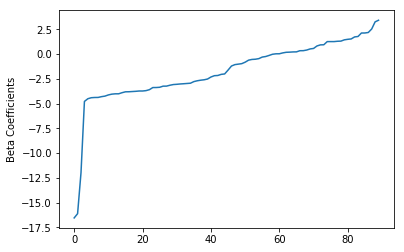

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()


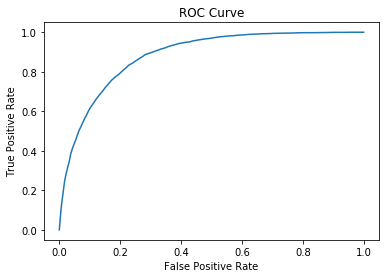

Area Under the Curve: 0.8814838048434834


In [49]:
# Let's get a summary of the data.
training_summary = lr_model.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

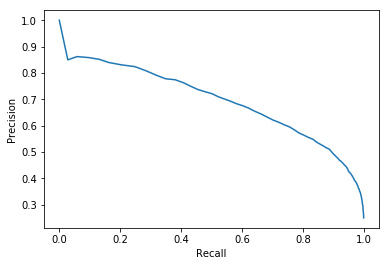

In [50]:
# Convert DataFrame to Pandas DataFrame.
pr = training_summary.pr.toPandas()

# Plot model recall and precision.
plt.plot(pr['recall'],pr['precision'])

# Define the labels and show the graph. 
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [51]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

(trainingData, testData) = df.randomSplit([0.7, 0.3])

dt = DecisionTreeRegressor(featuresCol="features")

pipeline = Pipeline(stages=[sex_indexer, occupation_indexer,workclass_indexer,nativecountry_indexer,maritalstatus_indexer, education_indexer, 
                             relationship_indexer, race_indexer,
                            income_indexer, occupation_encoder,workclass_encoder,nativecountry_encoder,maritalstatus_encoder, education_encoder,
                             relationship_encoder,race_encoder,
                            assembler,dt])
pipe_df = pipe_df.select('label', 'features')
pipeline_model = pipeline.fit(trainingData)
# Make predictions.
predictions = pipeline_model.transform(testData)
# Select example rows to display.
predictions.select('prediction', 'label', 'features').show(5)

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
|0.006786102062975...|  0.0|(90,[1,13,23,26,3...|
|0.006786102062975...|  0.0|(90,[1,13,23,26,4...|
|0.006786102062975...|  0.0|(90,[1,12,23,27,3...|
|0.006786102062975...|  0.0|(90,[1,12,23,26,3...|
|0.006786102062975...|  0.0|(90,[1,16,23,26,3...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [52]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0.353545


In [53]:
from pyspark.ml.linalg import Vector,Vectors
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer,VectorIndexer
from pyspark.ml.classification import DecisionTreeClassificationModel,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
labelIndexer = StringIndexer().setInputCol("income").setOutputCol("indexedLabel").fit(df)
labelConverter = IndexToString().setInputCol("prediction").setOutputCol("predictedLabel").setLabels(labelIndexer.labels)
dtClassifier = DecisionTreeClassifier().setLabelCol("label").setFeaturesCol("features")
pipeline = Pipeline(stages=[sex_indexer, occupation_indexer,workclass_indexer,nativecountry_indexer,maritalstatus_indexer, education_indexer, 
                             relationship_indexer, race_indexer,
                            income_indexer, occupation_encoder,workclass_encoder,nativecountry_encoder,maritalstatus_encoder, education_encoder,
                             relationship_encoder,race_encoder,
                            assembler,dtClassifier,labelConverter])
pipeline_model = pipeline.fit(df)


dtClassifiermodel = pipeline.fit(trainingData)

predictionsClassifier = dtClassifiermodel.transform(testData)

predictionsClassifier.select("predictedLabel", "label", "features").show(5)




+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|         <=50K|  0.0|(90,[1,13,23,26,3...|
|         <=50K|  0.0|(90,[1,13,23,26,4...|
|         <=50K|  0.0|(90,[1,12,23,27,3...|
|         <=50K|  0.0|(90,[1,12,23,26,3...|
|         <=50K|  0.0|(90,[1,16,23,26,3...|
+--------------+-----+--------------------+
only showing top 5 rows



In [54]:
evaluatorClassifier = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")
 
accuracy = evaluatorClassifier.evaluate(predictionsClassifier)
 
print("accuracy = " + str(accuracy))


accuracy = 0.8232532751091703


In [112]:
from pyspark.ml.regression import DecisionTreeRegressionModel,DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
dtRegressor = DecisionTreeRegressor().setLabelCol("label").setFeaturesCol("features")
pipeline= Pipeline(stages=[sex_indexer, occupation_indexer,workclass_indexer,nativecountry_indexer,maritalstatus_indexer, education_indexer, 
                             relationship_indexer, race_indexer,
                            income_indexer, occupation_encoder,workclass_encoder,nativecountry_encoder,maritalstatus_encoder, education_encoder,
                             relationship_encoder,race_encoder,
                            assembler,dtRegressor,labelConverter])

modelRegressor = pipeline.fit(trainingData)
predictionsRegressor = modelRegressor.transform(testData)
predictionsRegressor.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|         <=50K|  0.0|(90,[1,13,23,26,3...|
|         <=50K|  0.0|(90,[1,13,23,26,4...|
|         <=50K|  0.0|(90,[1,12,23,27,3...|
|         <=50K|  0.0|(90,[1,12,23,26,3...|
|         <=50K|  0.0|(90,[1,16,23,26,3...|
+--------------+-----+--------------------+
only showing top 5 rows



In [71]:
evaluatorRegressor = RegressionEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("rmse")
 
rmse = evaluatorRegressor.evaluate(predictionsRegressor)
 
print("Root Mean Squared Error (RMSE) on test data = " +str(rmse))


Root Mean Squared Error (RMSE) on test data = 0.3535446609477227


In [133]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
predictions.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+-------------+----------+--------------------+
|            features|label|rawPrediction|prediction|         probability|
+--------------------+-----+-------------+----------+--------------------+
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
|(90,[0,6,21,26,30...|  0.0|[406.0,838.0]|       1.0|[0.32636655948553...|
+--------------------+---

Test Area Under ROC: 0.7171283800213989


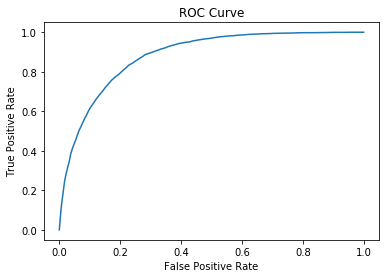

Area Under the Curve: 0.7171283800213989


In [134]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [135]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)
predictions.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(90,[0,6,21,26,30...|  0.0|[12.4228296099700...|       0.0|[0.62114148049850...|
|(90,[0,6,21,26,30...|  0.0|[12.4228296099700...|       0.0|[0.62114148049850...|
|(90,[0,6,21,26,30...|  0.0|[12.2812629339400...|       0.0|[0.61406314669700...|
|(90,[0,6,21,26,30...|  0.0|[12.2812629339400...|       0.0|[0.61406314669700...|
|(90,[0,6,21,26,30...|  0.0|[12.2812629339400...|       0.0|[0.61406314669700...|
|(90,[0,6,21,26,30...|  0.0|[12.2812629339400...|       0.0|[0.61406314669700...|
|(90,[0,6,21,26,30...|  0.0|[12.2812629339400...|       0.0|[0.61406314669700...|
|(90,[0,6,21,26,30...|  0.0|[12.2812629339400...|       0.0|[0.61406314669700...|
|(90,[0,6,21,26,30...|  0.0|[11.7042961062280...|       0.0|[0.58521480531140...|
|(90,[0,6,21,26,

Test Area Under ROC: 0.8597546250882127


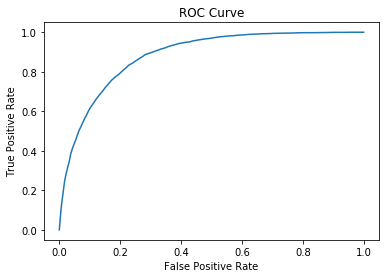

Area Under the Curve: 0.8597546250882127


In [136]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [157]:
# Importing the LR package.
from pyspark.ml.regression import LinearRegression

# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='label')

# Fit the training data.
lr_model = lr.fit(train_data)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
training_summary = lr_model.summary

# Print RMSE. 
print("RMSE: " + str(training_summary.rootMeanSquaredError))

# Print R2.
print("R2: " + str(training_summary.r2))

Coefficients: [-0.07739839372935713,-0.2303237584742556,-0.22250477922157402,-0.19630213570813704,-0.22979950263212787,-0.2043321070252082,0.07227552627004466,0.11909036883677672,0.2490983642984723,0.3448868075384356,0.1348388522810844,0.0463167677829084,0.14393515867110054,0.02415291421221593,-0.059874532474385365,0.49894622319858756,0.002830441108477207,0.08890424750900232,0.4839267301131005,-0.025063047469114533,-0.04034965151771753,0.16131450035751344,-0.014712031852076266,-0.01056456770486625,-0.02612675302145998,0.2043142355935802,0.04094484449221857,0.01759017352951696,0.036452153490505144,-0.010791861647271963,0.1707262622867152,0.09485575318859156,0.2490589047363399,0.08987491775849023,0.14838459514611285,0.07056063788803377,0.05961873362532009,0.08035064067841435,0.059977846720623215,0.025757247349347496,0.170354014505715,0.19720537284914885,0.08923469911859136,0.19757924436821214,0.13355613660397525,0.16448319726312136,0.13425758707547755,0.2898194942225357,0.267769910459012

In [158]:
train_data.describe().show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|              21052|
|   mean|0.24947748432452974|
| stddev| 0.4327208842386081|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [159]:
# Let's evaluate the model against the test data.
test_results = lr_model.evaluate(test_data)

# And print the RMSE/R2. As expected, our RMSE and R2 are slightly worse when applying the testing set.
print("RMSE on test data: " + str(test_results.rootMeanSquaredError))
print("R2 on test data: " + str(test_results.r2))

RMSE on test data: 0.35284843899271806
R2 on test data: 0.33176386047403605
